# Process Analysis

In any manufacture process, we have several stages in a pipeline that converts feedstock into releasable product. It can be all too easy to focus on each of these stages in their material complexity and lose sight of the overall pipeline (i.e. losing sight of the proverbial forest for the trees). Since the goal is to release high quality product as quickly as possible, a key managerial task is to design the process for efficiency. 

To manage such a process and potentially integrate efficiency enhancing resource reallocations or innovations, ideally we'd have some idea of what the impact of those changes would be. A clear view of impact requires us to choose the metrics we seek to optimize. We then need to be able to compare the baseline process to a process that incorporates changes in terms of these metrics. For example, if client release rate is our primary metric of interest, we should be able to understand if the improvement in release rate associated with hiring more people is worth the cost.

In this notebook we will work through an example of software development to fix these ideas. Methodologically, we will use both discrete event simulation and bayesian analysis to analyze a hypothetical process.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import xarray as xr
import pymc as pm
import numpy as np
import graphviz
import arviz as az
import pytensor.tensor as pt
import pytensor
from typing import Optional, Tuple, Set, List, Dict, Union
from statsconcepts.process import ProcessGraph, WidgetContainer, WidgetContainerGenerator, WidgetStore, Pipeline, Stage, Allocation
import simpy as sim
from dataclasses import dataclass
import logging
import pandas as pd

%load_ext autoreload
%aimport statsconcepts.process
%autoreload 1

## Synopsis of the Analytical Problem

### Motivation

In the competitive data industry, the ability to deliver new features quickly and efficiently is crucial. This requires optimizing the product development process to reduce bottlenecks, minimize cycle times, and maximize the feature release rate. Innovations like parallelizing development stages and automating tasks offer potential improvements, but their impact needs to be carefully evaluated.

### Process Description

The software development process consists of several key stages:

+ Requirements Specification
+ Enrichment
+ Modeling
+ Hydration
+ Testing
+ Deployment & Release

Initially, these stages are executed serially, with each stage depending on the completion of the previous one. However, there is potential to introduce parallelization, such as allowing Hydration and Testing to proceed concurrently after the Modeling is complete. The goal is to determine the optimal way to organize and execute these stages.

### Metrics to be Optimized

The primary metrics to be optimized in this analysis are:

+ **Feature Release Rate (Throughput):** The number of features released per unit of time.
+ **Pipeline Time (Cycle Time):** The average time it takes for a feature to move from initiation to release.
+ **Work-in-Progress (WIP):** The number of features in the development pipeline at any given time.

For the initial analysis, we will focus on Pipeline Time. Here is a depiction of the initial process.

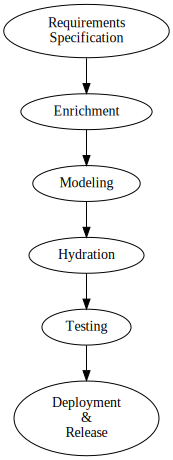

In [2]:
ProcessGraph.serial_data_dev()

### Bayesian Learning

Discrete event simulation is often executed deterministically. Conditional on specific starting conditions, the simulation will just run and generally lead to the same result each time. This is useful, but insufficient for our purposes for two reasons.

1. In the real world, there is variability in any given process. Process steps do not take precisely the same amount of time with each pass, and the feedstock going into any given process also changes for a variety of reasons.
2. We don't just want to simulate a process in an ungrounded way. Rather, we need some way of *calibrating* the simulation to accommodate what we know and observe in the world.

For this reason, it is useful to inject stochastic parameters into the simulation. In this first pass, we will introduce variability in the amount of work to do for any given tranche (i.e. `concept_dist`) and the length of time it takes to process a specific task/widget (i.e. `process_dist`). To introduce this variability, we are using a generative model (via `pymc`). This is useful because we are effectively just setting our prior distribution. We now can collect some empirical data from our observed process, compute the posterior, and then just use draws from that instead of our prior. In other words, we can calibrate our simulation to match what we observe.

*Note:* We make the strong assumption here that all tasks processing times are drawn from the same distribution with no conditioning, but this is not a constraint of the approach. It's just good practice to start simple and see where we need to extend. Even with this assumption, we can still understand the magnitude of speed up given resource reallocation or automation. It would be straightforward to introduce variation in task complexity and scope.

Sampling: [concept_dist, process_dist]


array([[<Axes: title={'center': 'process_dist'}>,
        <Axes: title={'center': 'concept_dist'}>]], dtype=object)

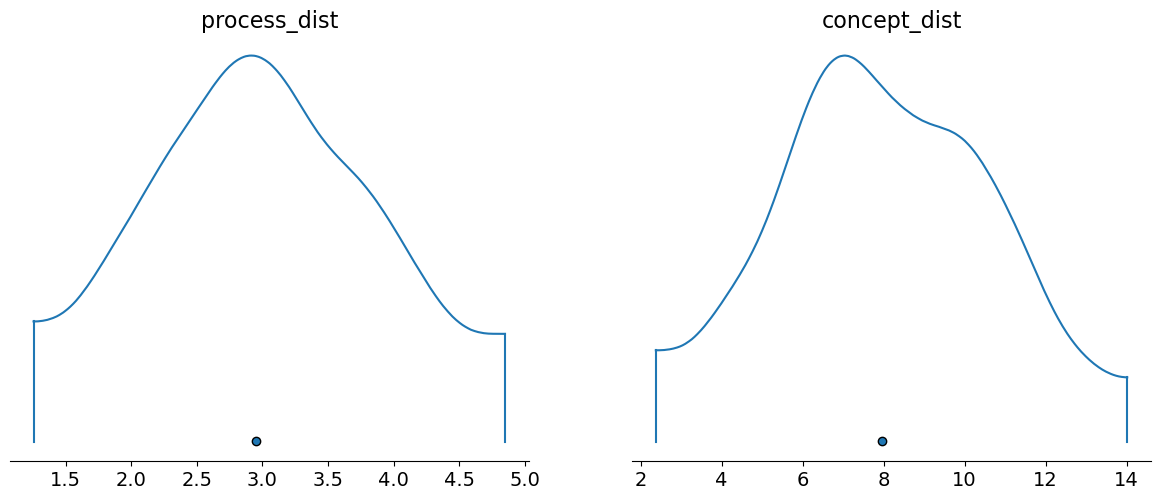

In [3]:
with pm.Model() as process_model:
    # Define priors
    concept_dist: pt.TensorVariable = pm.Normal("concept_dist", mu=8, sigma=3)
    process_dist: pt.TensorVariable = pm.Normal("process_dist", mu=3, sigma=1)
    

# pytensor.dprint(process_model)
process: az.InferenceData = pm.sample_prior_predictive(draws=1000, model=process_model)
az.plot_density(process.prior)

### Defining the Process

Our approach is going to be parametric in the process, defined here as a sequence of `Allocation` instances, each representing a step and paired with resources. We can define any number of steps and any resourcing level against those steps as inputs into the simulation. This provides us with the opportunity to compare different process designs. If we shift people to different parts of the process or automate steps, we can reflect that directly in the definition of the process. To compare two different processes, we just run the simulation twice with our two different process inputs.

*Note:* To keep it simple initially, we will presume serial execution and each tranche goes through the pipeline one at a time. The first assumption is material, but we can extend the simulation code to accommodate the dependencies required. Ideally, we'd be parametric in the process graph, not just a process sequence. Our current graph library (`graphviz`) is not very easy to interrogate, so we'll need a different package. The second assumption is less concerning. It just means we should interpret the simulation times as a conservative upper bound, but we can also update our ability to have multiple traches in flight simultaneously.

Once we have the processes defined, we can run an arbitrary number of simulations. In the code below, we run 100 simulations for `allocations_1` and 100 simulations for `allocations_2` to enable comparison. For each of the 200 total simulations we have a workload of 1000 tranches/containers with varying numbers of widgets in each.

In [9]:
# Initialize logger
logging.basicConfig(filename="process_analysis.log", level=logging.INFO, filemode="w")

# Set up stages and allocations
steps: List[str] = [line.split()[0] for line in ProcessGraph.serial_data_dev().body if "label" in line]
num_people_1: List[int] = [10, 10, 3, 3, 1, 1]
num_people_2: List[int] = [8, 8, 3, 3, 3, 3]
allocations_1: List[Allocation] = [Allocation(step=i, label=steps[i], n_people=num_people_1[i]) for i in range(len(steps))]
allocations_2: List[Allocation] = [Allocation(step=i, label=steps[i], n_people=num_people_2[i]) for i in range(len(steps))]


sims_by_allocation: xr.Dataset = Pipeline.simulations_across_allocations(
    n_sim=100,
    n_containers=1000,
    allocations={"alloc_1": allocations_1, "alloc_2": allocations_2},
    process_dist=process.prior.process_dist.values.flatten(),
    concept_dist=process.prior.concept_dist.values.flatten()
)


We store the output across all simulations in an `xarray` dataset, which makes it easy to stack simulations and distinguish relevant coordinates like pipeline, container, and stage.

In [10]:
sims_by_allocation

<xarray.Dataset> Size: 48MB
Dimensions:        (pipeline: 2, simulation: 100, container_id: 1000, stage: 6)
Coordinates:
  * pipeline       (pipeline) object 16B 'alloc_1' 'alloc_2'
  * simulation     (simulation) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * container_id   (container_id) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * stage          (stage) object 48B 'Deployment' 'Enrichment' ... 'Testing'
Data variables:
    num_widgets    (pipeline, simulation, container_id, stage) int64 10MB 6 ....
    process_time   (pipeline, simulation, container_id, stage) int64 10MB 12 ...
    start_time     (pipeline, simulation, container_id, stage) int64 10MB 34 ...
    end_time       (pipeline, simulation, container_id, stage) int64 10MB 46 ...
    num_resources  (pipeline, simulation, container_id, stage) int64 10MB 1 ....
Attributes:
    source:   source_0
    sink:     sink_0

### Metrics

In the plot below, we plot the distributions of pipeline time. The distributions are separated by the process (`alloc_1` vs `alloc_2`) for comparison. Within each distribution, we are observing the completion time for each simulation across all stages and containers. In effect, we are comparing when the pipeline is completed, conditional on the processes we defined as inputs.

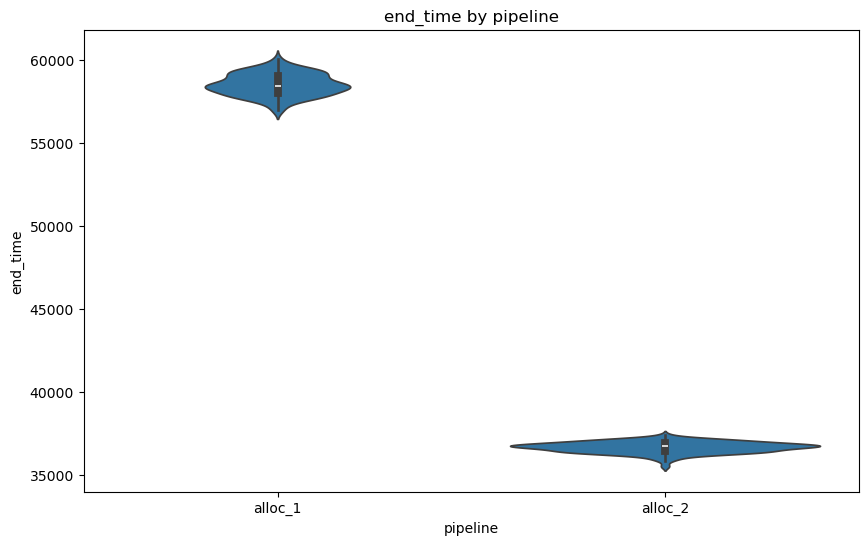

In [11]:
Pipeline.comparison_plot(
    ds=sims_by_allocation,
    measure="end_time",
    comparison_var="pipeline",
    observation_var="simulation",
    transform=lambda ds: ds.max(dim=["stage", "container_id"])
)

### Discussion

In our pipeline, we basically just moved two people from each of the first two stages to later stages that we under resourced. The impact of this move is to slow down the initial stages while speeding up the later stages, but the aggregate effect is difficult to reason about without simulation. Our intuition alone would not be precise enough to say that we expect to almost cut the pipeline time in half from this move, because it isn't a linear system. This is why discrete event simulation is useful - it helps us understand the system impacts of changes to nonlinear systems.

Importantly, simulation is also cheap. While there is a little bit of a curve to get up to speed on relevant simulation concepts and the specific simulation library used, this simulation is less than 500 lines of code. A experienced practicitioner could generate an MVP in an afternoon. Once built, many scenarios can be tested to help organizations identify where they can get the most bang for the buck with enough precision to order investments appropriately and set expectations about what the investments are likely to yield.
